<a href="https://colab.research.google.com/github/ElisabethDB/Eindopdracht-Deep-Learning/blob/main/3_VGG16_De_Bock_Elisabeth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

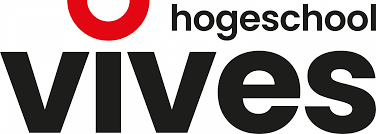<br>

**Deep Learning**<br>
Academiejaar 2022-2023<br>
De Bock Elisabeth

---

---


In [ ]:
#import libraries
import os, shutil, pathlib
import random
import math
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the root directory where the images are stored
rootdir= './drive/MyDrive/schilderijen' 

In [ ]:
# Set the categories (i.e. classes) of images
categories = ['Rubens', 'Picasso', 'Mondriaan']

In [ ]:
def plot_accuracy_los(accuracy, val_accuracy, loss,val_loss):
    epochs = range(1, len(accuracy) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(epochs, accuracy, "b", label="Training accuracy")
    ax1.plot(epochs, val_accuracy, "r", label="Validation accuracy")
    ax1.set_title("Accuracy")
    ax1.legend();

    ax2.plot(epochs, loss, "b", label="Training loss")
    ax2.plot(epochs, val_loss, "r", label="Validation loss")
    ax2.set_title("Loss")
    ax2.legend();

In [ ]:
train_dataset = image_dataset_from_directory(
    os.path.join(rootdir, "train"),
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    os.path.join(rootdir, "validation"),
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    os.path.join(rootdir, "test"),
    image_size=(180, 180),
    batch_size=32)

Found 387 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


#Feature extraction met VGG16

Listing 8.19 (p227) en 8.20 en 8.21 (p229)

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
    
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 25ms/step


In [ ]:
print('Training:')
print("\tfeatures:", train_features.shape)
print("\tlabels:", train_labels.shape)
print('Validation:')
print("\tfeatures:", val_features.shape)
print("\tlabels:", val_labels.shape)
print('Test:')
print("\tfeatures:", test_features.shape)
print("\tlabels:", test_labels.shape)

Training:
	features: (387, 5, 5, 512)
	labels: (387,)
Validation:
	features: (300, 5, 5, 512)
	labels: (300,)
Test:
	features: (300, 5, 5, 512)
	labels: (300,)


In [ ]:
inputs = keras.Input(shape=(5, 5, 512))  # krijgt output van convbase als input!
x = layers.Flatten()(inputs) 
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
  )

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/schilderijen_app/modellen/VGG16.keras",  # file waarin model wordt opgeslagen
    save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
    monitor="val_loss")
]

In [ ]:
history = model.fit(
    train_features, train_labels,
    epochs=40,
    validation_data=(val_features, val_labels),
    callbacks=callbacks,
)

Epoch 1/40
13/13 [==============================] - 2s 131ms/step - loss: 66.8039 - accuracy: 0.7028 - val_loss: 30.1228 - val_accuracy: 0.7133
Epoch 2/40
13/13 [==============================] - 0s 15ms/step - loss: 5.2198 - accuracy: 0.9432 - val_loss: 5.4636 - val_accuracy: 0.9300
Epoch 3/40
13/13 [==============================] - 0s 7ms/step - loss: 1.3619 - accuracy: 0.9638 - val_loss: 10.4110 - val_accuracy: 0.8933
Epoch 4/40
13/13 [==============================] - 0s 10ms/step - loss: 0.6352 - accuracy: 0.9845 - val_loss: 8.2285 - val_accuracy: 0.8733
Epoch 5/40
13/13 [==============================] - 0s 9ms/step - loss: 1.8959 - accuracy: 0.9793 - val_loss: 14.2095 - val_accuracy: 0.8767
Epoch 6/40
13/13 [==============================] - 0s 10ms/step - loss: 0.9687 - accuracy: 0.9845 - val_loss: 13.2626 - val_accuracy: 0.8633
Epoch 7/40
13/13 [==============================] - 0s 7ms/step - loss: 0.5744 - accuracy: 0.9871 - val_loss: 7.5088 - val_accuracy: 0.9133
Epoch 8/40

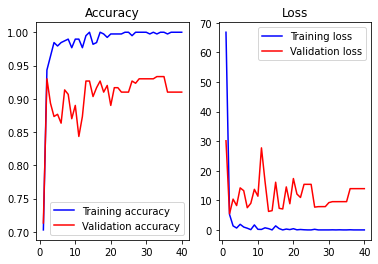

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plot_accuracy_los(accuracy, val_accuracy, loss,val_loss)

In [ ]:
test_model = keras.models.load_model("/content/drive/MyDrive/schilderijen_app/modellen/VGG16.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels) 
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 0s 3ms/step - loss: 15.9446 - accuracy: 0.8767
Test accuracy: 0.877


# Feature extraction met VGG16 en met data augmentation: 
Listing 8.23 (p231) en 8.25 (p232)

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
)

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weight tensors "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weight tensors before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weight tensors "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weight tensors after freezing the conv base: 0


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs) 
x = keras.applications.vgg16.preprocess_input(x) 
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)

In [ ]:
model = keras.Model(inputs, outputs)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
  )

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/schilderijen_app/modellen/VGG16_data_augementation.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/40
13/13 [==============================] - 6s 376ms/step - loss: 84.7206 - accuracy: 0.6047 - val_loss: 12.3300 - val_accuracy: 0.8667
Epoch 2/40
13/13 [==============================] - 3s 233ms/step - loss: 11.2226 - accuracy: 0.8708 - val_loss: 17.3650 - val_accuracy: 0.8233
Epoch 3/40
13/13 [==============================] - 3s 234ms/step - loss: 8.3337 - accuracy: 0.9044 - val_loss: 23.9004 - val_accuracy: 0.8400
Epoch 4/40
13/13 [==============================] - 5s 350ms/step - loss: 6.1249 - accuracy: 0.9121 - val_loss: 10.6184 - val_accuracy: 0.8633
Epoch 5/40
13/13 [==============================] - 4s 258ms/step - loss: 4.3545 - accuracy: 0.9380 - val_loss: 7.7172 - val_accuracy: 0.9100
Epoch 6/40
13/13 [==============================] - 3s 235ms/step - loss: 4.8438 - accuracy: 0.9302 - val_loss: 21.2843 - val_accuracy: 0.8100
Epoch 7/40
13/13 [==============================] - 3s 241ms/step - loss: 5.6441 - accuracy: 0.9225 - val_loss: 10.7186 - val_accuracy: 0.883

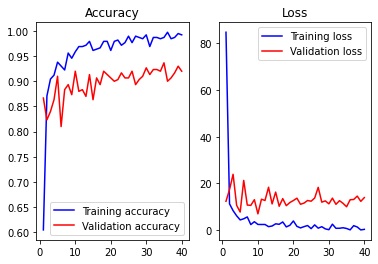

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plot_accuracy_los(accuracy, val_accuracy, loss,val_loss)

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/schilderijen_app/modellen/VGG16_data_augementation.keras")
test_loss, test_acc = model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 2s 108ms/step - loss: 22.1017 - accuracy: 0.8667
Test accuracy: 0.867


# Finetuning van VGG16 conv base

Listing 8.27 en 8.28 (p236)

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
# gewichten toekennen aan nieuwe variabele (zie verder)
weights_before = model.weights

Model hercompileren

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),  # kleine learning rate nemen!
    metrics=["accuracy"]
)

Model hertrainen

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/schilderijen_app/modellen/fine_tuning_VGG16.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/40
13/13 [==============================] - 4s 271ms/step - loss: 6.2285 - accuracy: 0.9664 - val_loss: 10.4024 - val_accuracy: 0.8900
Epoch 2/40
13/13 [==============================] - 4s 258ms/step - loss: 3.0377 - accuracy: 0.9690 - val_loss: 6.8087 - val_accuracy: 0.9133
Epoch 3/40
13/13 [==============================] - 4s 260ms/step - loss: 1.8614 - accuracy: 0.9793 - val_loss: 6.4934 - val_accuracy: 0.9267
Epoch 4/40
13/13 [==============================] - 3s 237ms/step - loss: 1.5269 - accuracy: 0.9742 - val_loss: 8.5953 - val_accuracy: 0.8967
Epoch 5/40
13/13 [==============================] - 3s 243ms/step - loss: 2.0783 - accuracy: 0.9690 - val_loss: 19.3356 - val_accuracy: 0.8600
Epoch 6/40
13/13 [==============================] - 3s 242ms/step - loss: 1.2484 - accuracy: 0.9793 - val_loss: 18.2125 - val_accuracy: 0.8933
Epoch 7/40
13/13 [==============================] - 3s 238ms/step - loss: 2.5365 - accuracy: 0.9587 - val_loss: 9.2613 - val_accuracy: 0.9067
Epo

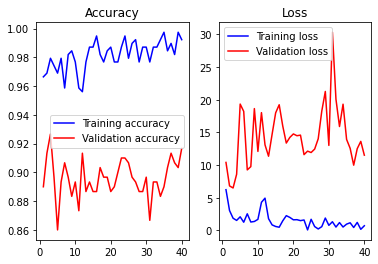

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plot_accuracy_los(accuracy, val_accuracy, loss,val_loss)

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/schilderijen_app/modellen/fine_tuning_VGG16.keras")
test_loss, test_acc = model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 2s 106ms/step - loss: 21.1503 - accuracy: 0.8700
Test accuracy: 0.870


# Modellen testen

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/schilderijen_app/modellen/VGG16.keras")

In [ ]:
# Load the image and preprocess it
img = Image.open('/content/drive/MyDrive/Mondriaan/NewYorkCityI_Piet_Mondriaan.jpg')
img_new = img.resize((180, 180))  # Resize the image to 180*180
img_new = np.array(img_new) / 255.0  # Normalize the pixel values

# Make a prediction on the image
predictions = model.predict(np.expand_dims(img_new, axis=0))

# Determine the class with the highest probability
predicted_class = np.argmax(predictions)

# Map the integer class label to a string label
predicted_label = categories[predicted_class]

plt.imshow(img)
print(f"Computer says: {predicted_label}")

In [ ]:
model2 = keras.models.load_model("/content/drive/MyDrive/schilderijen_app/modellen/VGG16_data_augementation.keras")

In [ ]:
# Load the image and preprocess it
img = Image.open('/content/drive/MyDrive/Mondriaan/NewYorkCityI_Piet_Mondriaan.jpg')
img_new = img.resize((180, 180))  # Resize the image to 180*180
img_new = np.array(img_new) / 255.0  # Normalize the pixel values

# Make a prediction on the image
predictions = model2.predict(np.expand_dims(img_new, axis=0))

# Determine the class with the highest probability
predicted_class = np.argmax(predictions)

# Map the integer class label to a string label
predicted_label = categories[predicted_class]

plt.imshow(img)
print(f"Computer says: {predicted_label}")

In [ ]:
model3 = keras.models.load_model("/content/drive/MyDrive/schilderijen_app/modellen/fine_tuning_VGG16.keras")

In [ ]:
# Load the image and preprocess it
img = Image.open('/content/drive/MyDrive/Mondriaan/NewYorkCityI_Piet_Mondriaan.jpg')
img_new = img.resize((180, 180))  # Resize the image to 180*180
img_new = np.array(img_new) / 255.0  # Normalize the pixel values

# Make a prediction on the image
predictions = model3.predict(np.expand_dims(img_new, axis=0))

# Determine the class with the highest probability
predicted_class = np.argmax(predictions)

# Map the integer class label to a string label
predicted_label = categories[predicted_class]

plt.imshow(img)
print(f"Computer says: {predicted_label}")